## Discrete signals

Consider a function $f(x)$ defined on an integer grid $x \in \mathbb Z$.

We also consider the Fourier modes
$$ e^{i\theta x} $$
for continuous $\theta$.
Is it possible to distinguish $e^{i\theta x}$ from $e^{i(\theta+2\pi)x}$?

In [56]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
plt.style.use('ggplot')

@widgets.interact(theta=widgets.FloatSlider(min=-5, max=5, value=1))
def signalplot(theta):
    x = np.linspace(-5, 5, 200)
    xx = np.linspace(-5, 5, dtype=int)
    plt.plot(x, np.sin(theta*x))
    plt.plot(xx, np.sin(theta*xx), 'ok');
    plt.plot(x, np.sin((theta-2*np.pi)*x));
    plt.plot(x, np.sin((theta+2*np.pi)*x));

interactive(children=(FloatSlider(value=1.0, description='theta', max=5.0, min=-5.0), Output()), _dom_classes=…

The limit $\theta=\pi$ is known as the Nyquist frequency, beyond which there exists a lower frequency signal that matches at all the integer points.

In [57]:
@widgets.interact(n=widgets.IntSlider(min=1, max=30, value=2))
def vplot(n):
    x = np.linspace(-5, 5, 200)
    plt.plot(x, np.sin(x))
    plt.plot(x, np.sin(x) + np.sin(2*x)/2);
    plt.plot(x, np.sum([np.sin(k*x)/k for k in range(1,n+1)], axis=0));

interactive(children=(IntSlider(value=2, description='n', max=30, min=1), Output()), _dom_classes=('widget-int…

### Approximation via Fourier basis

It turns out that we can approximate any function $f(x)$ by a linear combination of Fourier modes

$$ f(x) \approx \sum_{k=1}^n \hat f(\theta_k) e^{i\theta_k x} . $$

This is reminiscent of linear algebra

$$ \Bigg[ f(x) \Bigg] = \Bigg[ e^{i\theta_1 x} \Bigg| e^{i\theta_2 x} \Bigg| \dotsm \Bigg] \begin{bmatrix} \hat f(\theta_1) \\ \hat f(\theta_2) \\ \vdots \end{bmatrix}
= \Bigg[ e^{i\theta_1 x} \Bigg] \hat f(\theta_1) + \Bigg[ e^{i\theta_2 x} \Bigg] \hat f(\theta_2) + \dotsb . $$

If we take $\theta \in (-\pi, \pi]$ as a continuous quantity (instead of a discrete set of modes), the sum becomes and integral and we get equality (for "nice enough" $f(x)$),

$$ f(x) = \int_{-\pi}^\pi \hat f(\theta) e^{i\theta x} d\theta, $$

in which $\hat f(\theta)$ is the Fourier transform (specifically, the [discrete time transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform)) of $f(x)$.  This representation is valuable for analyzing convergence of multigrid methods, among other applications.

#### Computing $\hat f(\theta)$

If we select a finite number of points $x$ and compute the square Vandermonde matrix

$$ \mathcal F = \Bigg[ e^{i\theta_1 x} \Bigg| e^{i\theta_2 x} \Bigg| \dotsm \Bigg] $$

then, knowing the vector $f$, we could solve

$$ \mathcal F \hat f = f $$

for $\hat f$.  This would require $O(n^3)$ where $n$ is the number of points.

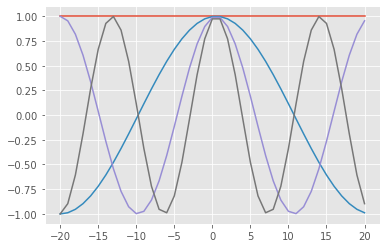

In [61]:
def fourier_vander(x, n=None):
    """Create the Vandermonde matrix with columns """
    if n is None:
        n = len(x)
    theta = -np.pi + 2*np.pi*np.arange(n)/n
    F = np.exp(1j*np.outer(theta, x))
    return F

x = np.linspace(-20, 20, 41, dtype=int)
F = fourier_vander(x)
plt.plot(x, F[:,20:24].real);

In [41]:
x = np.linspace(-2, 2, 5, dtype=int)
F = fourier_vander(x)
np.real_if_close(F.conj().T @ F)

array([[ 5.00000000e+00,  1.42128110e-16, -2.22044605e-16,
        -2.58840649e-17,  8.88178420e-16],
       [ 1.42128110e-16,  5.00000000e+00,  1.11022302e-16,
        -4.44089210e-16, -2.58840649e-17],
       [-2.22044605e-16,  1.11022302e-16,  5.00000000e+00,
         1.11022302e-16, -2.22044605e-16],
       [-2.58840649e-17, -4.44089210e-16,  1.11022302e-16,
         5.00000000e+00,  1.42128110e-16],
       [ 8.88178420e-16, -2.58840649e-17, -2.22044605e-16,
         1.42128110e-16,  5.00000000e+00]])

In [42]:
np.linalg.norm(F.conj().T @ F - 5*np.eye(5))

1.9697658314011113e-15

Evidently $\mathcal F$ (modulo normalization) is a unitary matrix, meaning that $\mathcal F^H \mathcal F = I$.  This means we can compute $\hat f$ with only multiplication, a cost of $O(n^2)$.  (Of course we don't need to store $\mathcal F$ because its action can be evaluated on the fly.)

## Faster!

In this discrete context, the transform we need to evaluate is

$$ \hat f_k = \sum_\ell e^{-i\theta_k x_\ell} f_\ell $$

where $f_\ell$ are samples $f(x_\ell)$ at integers $x_\ell = \ell$ and $\theta_k$ are the frequencies $2 \pi k/n$ (because the branch $(-\pi, \pi]$ is arbitrary).

\begin{align}
\hat f_k &= \sum_{\ell=0}^{n-1} e^{-2\pi i \frac{k \ell}{n}} f_\ell \\
 &= \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k (2\ell)}{n}} f_{2\ell}}_{\text{even}} +
 \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k (2\ell+1)}{n}} f_{2\ell+1}}_{\text{odd}} \\
 &= \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell}}_{\text{transform of even data}} + e^{-2\pi i \frac k n} \underbrace{\sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell+1}}_{\text{transform of odd data}}
\end{align}

When the original signal $f$ is periodic, $f_{\ell} = f_{\ell + n \bmod n}$, then
\begin{align}
\hat f_{k+n/2} &= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{(k+n/2) \ell}{n/2}} f_{2\ell} + e^{-2\pi i \frac{(k+n/2)}{n}} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{(k+n/2) \ell}{n/2}} f_{2\ell+1} \\
&= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell} + e^{-2\pi i \frac{k}{n}} e^{-\pi i} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k\ell}{n/2}} f_{2\ell+1} \\
&= \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell} - e^{-2\pi i \frac{k}{n}} \sum_{\ell=0}^{n/2-1} e^{-2\pi i \frac{k \ell}{n/2}} f_{2\ell+1}
\end{align}
where we have used that
$$ e^{-2\pi i \ell} = \Big( e^{-2\pi i} \Big)^\ell = 1^\ell = 1 .$$

We've reduced a Fourier transform of length $n$ (at a cost of $n^2$) to two transforms of length $n/2$ (at a cost of $2 n^2/4 = n^2/2$).
Repeating this recursively yields a complexity of $O(n\log n)$.

In [67]:
@widgets.interact(m=widgets.IntSlider(min=1, max=10, value=1))
def plot_fft(m):
    n = 64
    x = np.arange(n)
    f = np.exp(2j*np.pi*m*x/n)
    fhat = np.fft.fft(f)
    plt.plot(x, f)
    plt.plot(fhat / np.linalg.norm(fhat, np.inf))

interactive(children=(IntSlider(value=1, description='m', max=10, min=1), Output()), _dom_classes=('widget-int…

In [76]:
@widgets.interact(m=widgets.IntSlider(min=1, max=20, value=1))
def plot_fft_sawtooth(m):
    n = 64
    x = np.arange(n)
    g = np.sum([np.sin(2*np.pi*k*x/n)/k for k in range(1,m+1)], axis=0)
    ghat = np.fft.fft(g)
    plt.plot(x, g)
    plt.plot(1j*ghat / np.linalg.norm(ghat, np.inf))

interactive(children=(IntSlider(value=1, description='m', max=20, min=1), Output()), _dom_classes=('widget-int…

### Parallel limitation: bisection bandwidth

### Applications

* Signal processing, compression, etc.
* Differentiation and PDEs
* Chebyshev polynomials
* Butterfly algorithms for integral operators
$$ (\mathcal K f)(x) = \int_{Y} K(x,y) f(y) dy $$
See [Poulson et al., A parallel butterfly algorithm](https://math.mit.edu/icg/papers/butterfly-parallel.pdf)